In [0]:
import sys
sys.path.append('../')

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from MaskedRNN import MaskedDeepRNN
from MaskedRNN import weight_prune

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
sns.set_style('darkgrid')

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

#### Import, shuffle and split dataset

In [0]:
data = pd.read_csv('reber_sequences.csv')

In [0]:
data = data.sample(frac=1).reset_index(drop=True)

In [0]:
train_data = data[:int(.75*len(data))]
test_data = data[len(train_data):]

In [8]:
print('Total length: {}\nTrain data length: {}\nTest data length: {}'.format(len(data), len(train_data), len(test_data)))

Total length: 25000
Train data length: 18750
Test data length: 6250


#### Parameters

In [0]:
MODEL = 'gru'

In [0]:
BATCH_SIZE = 16

INPUT_SIZE = 128
EMBEDDING_DIM = 100
OUTPUT_SIZE = 2

EPOCHS = 30
HIDDEN_LAYERS = [100, 100, 100]

#### Customize `Dataset`

In [0]:
class MakeDataset(Dataset):
    def __init__(self, data):
        self.strings = list(data['string'])
        self.valid = list(data['valid'])
        self.len = len(self.valid)
        self.valid_list = [0, 1]

    def __getitem__(self, index):
        return self.strings[index], self.valid[index]

    def __len__(self):
        return self.len

#### Train/Test Loader

In [0]:
dataset = MakeDataset(train_data)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
dataset = MakeDataset(test_data)
test_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Helper functions

In [0]:
def create_variable(tensor):
    return Variable(tensor.to(device))

In [0]:
def pad_seq(vect_seqs, seq_lens, valid):
    seq_tensor = torch.zeros((len(vect_seqs), seq_lens.max())).long()
    
    for index, (seq, seq_len) in enumerate(zip(vect_seqs, seq_lens)):
        seq_tensor[index, :seq_len] = torch.LongTensor(seq)
        
    return create_variable(seq_tensor), create_variable(seq_lens), create_variable(valid)

In [0]:
def str2ascii(string):
    ascii_arr = [ord(s) for s in string]
    return ascii_arr, len(ascii_arr)

In [0]:
def make_variables(strings, valid):
    seqs_and_lens = [str2ascii(string)for string in strings]
    vect_seqs = [s[0] for s in seqs_and_lens]
    seq_lens = torch.LongTensor([s[1] for s in seqs_and_lens])
    valid = torch.LongTensor(valid)
    return pad_seq(vect_seqs, seq_lens, valid)

#### Model

In [0]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers: list, mode):
        super(Model, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_layers[0]).to(device)
        self.recurrent = MaskedDeepRNN(hidden_layers[0], hidden_layers, mode=mode).to(device)
        self.fc = nn.Linear(hidden_layers[-1], output_size).to(device)
        
    def forward(self, input):
        input = input.t()
        embedded = self.embedding(input)
        output = self.recurrent(embedded)
        return self.fc(output)

In [0]:
model = Model(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS, mode='gru')

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [21]:
print(model)

Model(
  (embedding): Embedding(128, 100)
  (recurrent): MaskedDeepRNN(
    (recurrent_layers): ModuleList(
      (0): MaskedRecurrentLayer(100, 100)
      (1): MaskedRecurrentLayer(100, 100)
      (2): MaskedRecurrentLayer(100, 100)
    )
  )
  (fc): Linear(in_features=100, out_features=2, bias=True)
)


#### Train & Test

In [0]:
def train():
    total_loss = 0
    
    for i, (string, valid) in enumerate(train_loader, 1):
        input, seq_lens, target = make_variables(string, valid)

        output = model(input)
        
        loss = criterion(output, target)
        total_loss += loss.data.item()
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('{}/{}\tLoss: {:.5f}'.format(i * len(string), len(train_loader.dataset), total_loss / i * len(string)))

In [0]:
test_acc = []

In [0]:
def test():
    correct = 0.
    test_data_size = len(test_loader.dataset)
    
    for string, valid in test_loader:
        input, seq_lens, target = make_variables(string, valid)

        output = model(input)

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    acc = 100 * correct / test_data_size
    test_acc.append(acc)
        
    print('\nAccuracy: {:.2f}%\n'.format(acc))

In [25]:
%%time
for epoch in range(1, EPOCHS+1):
    print('Epoch #{}\n{}'.format(epoch, 12*'-'))
    train()
    test()

Epoch #1
------------
1600/18750	Loss: 6.01223
3200/18750	Loss: 4.82187
4800/18750	Loss: 4.13105
6400/18750	Loss: 3.41686
8000/18750	Loss: 2.92345
9600/18750	Loss: 2.44749
11200/18750	Loss: 2.09926
12800/18750	Loss: 1.83762
14400/18750	Loss: 1.63434
16000/18750	Loss: 1.47135
17600/18750	Loss: 1.33812

Accuracy: 100.00%

Epoch #2
------------
1600/18750	Loss: 0.00195
3200/18750	Loss: 0.00175
4800/18750	Loss: 0.00162
6400/18750	Loss: 0.00149
8000/18750	Loss: 0.00140
9600/18750	Loss: 0.00131
11200/18750	Loss: 0.00124
12800/18750	Loss: 0.00117
14400/18750	Loss: 0.00111
16000/18750	Loss: 0.00106
17600/18750	Loss: 0.00101

Accuracy: 100.00%

Epoch #3
------------
1600/18750	Loss: 0.00045
3200/18750	Loss: 0.00044
4800/18750	Loss: 0.00043
6400/18750	Loss: 0.00041
8000/18750	Loss: 0.00040
9600/18750	Loss: 0.00039
11200/18750	Loss: 0.00037
12800/18750	Loss: 0.00036
14400/18750	Loss: 0.00035
16000/18750	Loss: 0.00034
17600/18750	Loss: 0.00033

Accuracy: 100.00%

Epoch #4
------------
1600/18750	L

#### Plot & Save

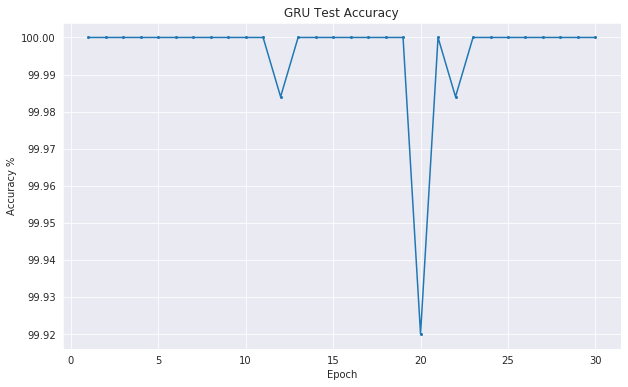

In [26]:
plt.figure(figsize=(10, 6))
plt.title('{} Test Accuracy'.format(MODEL.upper()))
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.savefig('{}-accuracy.png'.format(MODEL))
plt.plot(range(1, len(test_acc)+1), test_acc, marker='o', ms='2');

In [0]:
with open('{}-accuracies.txt'.format(MODEL), 'a') as f:
    f.write('{}'.format(MODEL.upper()) + ':' + ','.join(str(a.item()) for a in test_acc) + '\n')

In [0]:
torch.save(model.state_dict(), './{}-dict.pt'.format(MODEL))

#### Parameters Info

In [29]:
next(model.parameters()).is_cuda

True

In [0]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [31]:
total_params, trainable_params = count_parameters(model)
print('Total parameters: {}\nTrainable parameters: {}'.format(total_params, trainable_params))

Total parameters: 194802
Trainable parameters: 194802


In [32]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print('{}: {}'.format(name, param.data.nelement()))

embedding.weight: 12800
recurrent.recurrent_layers.0.weight_ih: 30000
recurrent.recurrent_layers.0.weight_hh: 30000
recurrent.recurrent_layers.0.bias_ih: 300
recurrent.recurrent_layers.0.bias_hh: 300
recurrent.recurrent_layers.1.weight_ih: 30000
recurrent.recurrent_layers.1.weight_hh: 30000
recurrent.recurrent_layers.1.bias_ih: 300
recurrent.recurrent_layers.1.bias_hh: 300
recurrent.recurrent_layers.2.weight_ih: 30000
recurrent.recurrent_layers.2.weight_hh: 30000
recurrent.recurrent_layers.2.bias_ih: 300
recurrent.recurrent_layers.2.bias_hh: 300
fc.weight: 200
fc.bias: 2


#### Weights

In [0]:
weights = [model.recurrent.recurrent_layers[0].weight_ih, model.recurrent.recurrent_layers[0].weight_hh,
           model.recurrent.recurrent_layers[1].weight_ih, model.recurrent.recurrent_layers[1].weight_hh,
           model.recurrent.recurrent_layers[2].weight_ih, model.recurrent.recurrent_layers[2].weight_hh]

In [0]:
titles = ['Recurrent Layer 1 - weight_ih', 'Recurrent Layer 1 - weight_hh',
          'Recurrent Layer 2 - weight_ih', 'Recurrent Layer 2 - weight_hh',
          'Recurrent Layer 3 - weight_ih', 'Recurrent Layer 3 - weight_hh']

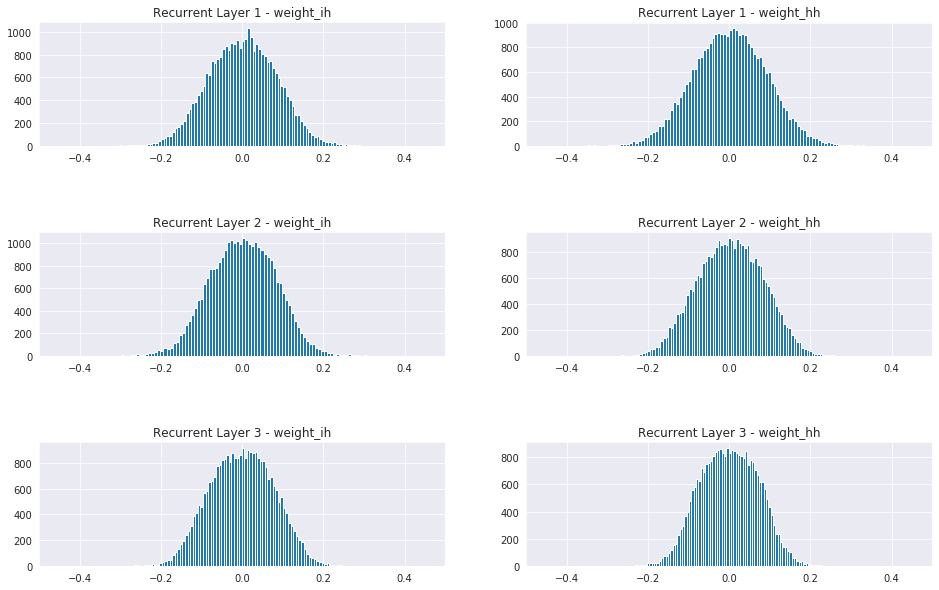

In [35]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=0.7)
for i, weight in enumerate(weights):
    plt.subplot(3,2,i+1)
    plt.title('{}'.format(titles[i]))
    plt.hist(weight.cpu().detach().numpy().reshape(-1), bins=100)
    plt.xlim(-0.5, 0.5)
plt.savefig('{}-weights.png'.format(MODEL))